In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from Preprocessingfunctions import convertclock,OutlierDetection
import statsmodels.api as spearman
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from matplotlib import cm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder
import pickle

shotlogs=pd.read_csv('shot_logs.csv')
shotlogs.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


In [2]:
shotlogs.describe()
print(f"Dataset Shape: {shotlogs.shape[0]} rows, {shotlogs.shape[1]} cols")

Dataset Shape: 128069 rows, 21 cols


In [3]:
# shotlogs.isnull().sum().sort_values(ascending=False)

For shots that occur at the end of quarters, place the time left on clock in the missing shot clock entries

In [4]:
shotlogs['GAME_CLOCK']=shotlogs['GAME_CLOCK'].apply(convertclock)
shotlogs['GAME_CLOCK']=pd.to_numeric(shotlogs['GAME_CLOCK'], errors='coerce')
shotlogs['SHOT_CLOCK']=shotlogs['SHOT_CLOCK'].fillna(shotlogs['GAME_CLOCK'])
shotlogs['SHOT_CLOCK']=pd.to_numeric(shotlogs['SHOT_CLOCK'], errors='coerce')

Convert binary text columns ('LOCATION','W','SHOT_RESULT) to 0s and 1s

In [5]:
shotlogs['LOCATION']=np.where(shotlogs['LOCATION']=='A',0,1)
shotlogs['W']=np.where(shotlogs['W']=='W',1,0)
shotlogs['SHOT_RESULT']=np.where(shotlogs['SHOT_RESULT']=='made',1,0)

Outlier Detection

Outlier handling for Master DataFrame, based upon boxplots found in Univariate_EDA; SHOT_DIST, TOUCH_TIME and CLOSE_DEF_DIST have the greatest number of outliers.

In [6]:
OutlierDetection(shotlogs[['SHOT_DIST','TOUCH_TIME','CLOSE_DEF_DIST']])

/Users/michaelgriffin/TensorFlowProject/TensorFlow-First-Project/Functions/Preprocessingfunctions.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df=clean_df[mask]


,SHOT_DIST,TOUCH_TIME,CLOSE_DEF_DIST
0,7.7,1.9,1.3
1,28.2,0.8,6.1
2,10.1,2.7,0.9
3,17.2,1.9,3.4
4,3.7,2.7,1.1
...,...,...,...
128064,8.7,6.2,0.8
128065,0.6,5.2,0.6
128066,16.9,4.2,4.2
128067,18.3,4.5,3.0


Feature Engineering

Matchup splits into DateTime, then arena in which the game took place and then the team for which the player played

In [7]:
shotlogs[['Date','Matchup']]=shotlogs['MATCHUP'].str.split('-', expand=True)

In [8]:
shotlogs[['Away Team','Home Team']]=shotlogs['Matchup'].str.split('@', expand=True)

In [9]:
final_shotlog=shotlogs.drop(['MATCHUP'],axis=1)

Convert 'Date' to datetime object

In [10]:
final_shotlog['Date']=pd.to_datetime(final_shotlog['Date'], format='%b %d, %Y ')


Create Feature 'Player Team', which identifies the team to which the shooting player belongs

In [11]:
final_shotlog['Player_Team']=final_shotlog.apply(lambda row: row['Away Team'] if ['LOCATION'] == 'A' else row['Home Team'], axis=1)  

Convert

Calculate player's field goal percentage

In [15]:
fg=final_shotlog.groupby(['player_name'])['SHOT_RESULT'].mean()
final_shotlog['player field goal percentage']=final_shotlog['player_name'].map(fg)


Calculate each defender's field goal percentage against

In [16]:
final_shotlog['Defender Field goal Percentage against']=final_shotlog.groupby(['CLOSEST_DEFENDER_PLAYER_ID'])['SHOT_RESULT'].transform('mean')

In [17]:
final_shotlog.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,...,PTS,player_name,player_id,Date,Matchup,Away Team,Home Team,Player_Team,player field goal percentage,Defender Field goal Percentage against
0,21400899,0,1,24,1,1,69,10.8,2,1.9,...,2,brian roberts,203148,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.400538,0.454308
1,21400899,0,1,24,2,1,14,3.4,0,0.8,...,0,brian roberts,203148,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.400538,0.406250
2,21400899,0,1,24,3,1,0,0.0,3,2.7,...,0,brian roberts,203148,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.400538,0.406250
3,21400899,0,1,24,4,2,707,10.3,2,1.9,...,0,brian roberts,203148,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.400538,0.460000
4,21400899,0,1,24,5,2,634,10.9,2,2.7,...,0,brian roberts,203148,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.400538,0.481203


Calculating each players Effective Field Goal Percentage, which weights three point shots (FGM +(0.5 * 3PM)/FGA), and each defenders EFG against.

In [18]:
EFG_CALC=final_shotlog[['player_name','player_id','SHOT_RESULT','PTS']].copy(deep=True)
DEFG_CALC=final_shotlog[['CLOSEST_DEFENDER','CLOSEST_DEFENDER_PLAYER_ID','SHOT_RESULT','PTS']].copy(deep=True)

In [19]:
total_attempts=EFG_CALC['player_name'].value_counts()
makes=EFG_CALC.groupby(['player_name'])['PTS'].value_counts()
two_pt_makes=makes.xs(2,level='PTS')
three_pt_makes=makes.xs(3, level='PTS')

efg=pd.DataFrame({
    'Total Attempts':total_attempts,
    'Two Point Makes':two_pt_makes,
    'Three Point Makes':three_pt_makes
})

total_attempts=DEFG_CALC['CLOSEST_DEFENDER'].value_counts()
makes=DEFG_CALC.groupby(['CLOSEST_DEFENDER'])['PTS'].value_counts()
two_pt_makes=makes.xs(2,level='PTS')
three_pt_makes=makes.xs(3, level='PTS')

defg=pd.DataFrame({
    'Total Attempts':total_attempts,
    'Two Point Makes':two_pt_makes,
    'Three Point Makes':three_pt_makes
})



In [20]:
efg['EFG']= ((efg['Two Point Makes']+efg['Three Point Makes'])+(0.5*efg['Three Point Makes']))/efg['Total Attempts']
efg=efg.drop(['Total Attempts','Two Point Makes','Three Point Makes'],axis=1)



defg['DEFG']= ((defg['Two Point Makes']+defg['Three Point Makes'])+(0.5*defg['Three Point Makes']))/defg['Total Attempts']
defg=defg.drop(['Total Attempts','Two Point Makes','Three Point Makes'],axis=1)

In [21]:
final_shotlog['EFG']=final_shotlog['player_name'].map(efg['EFG'])
final_shotlog['DEFG']=final_shotlog['CLOSEST_DEFENDER'].map(defg['DEFG'])

In [33]:
final_shotlog.describe()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,PTS,player_id,player field goal percentage,Defender Field goal Percentage against,EFG,DEFG,PC1,PC2
count,1.280690e+05,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,113303.000000,127845.000000,1.280690e+05,1.280690e+05
mean,2.140045e+07,0.499215,0.504377,0.208723,6.506899,351.393811,17.932493,13.571504,0.452139,159038.487284,4.123015,0.997314,157238.251247,0.452139,0.452139,0.495958,0.498721,5.770049e-17,-4.837964e-17
std,2.578773e+02,0.500001,0.499983,13.233267,4.713260,207.590603,51.834789,8.888964,0.497706,78791.172947,2.756446,1.130978,79362.389336,0.052171,0.038569,0.039964,0.042608,1.407271e+00,1.019040e+00
min,2.140000e+07,0.000000,0.000000,-53.000000,1.000000,0.000000,0.000000,0.000000,0.000000,708.000000,0.000000,0.000000,708.000000,0.308511,0.000000,0.347032,0.234375,-3.829535e+01,-2.443819e+00
25%,2.140023e+07,0.000000,0.000000,-8.000000,3.000000,172.000000,8.000000,4.700000,0.000000,101249.000000,2.300000,0.000000,101162.000000,0.416816,0.430034,0.470990,0.473934,-8.102373e-01,-7.359282e-01
50%,2.140045e+07,0.000000,1.000000,1.000000,5.000000,352.000000,12.200000,13.700000,0.000000,201949.000000,3.700000,0.000000,201939.000000,0.448674,0.452632,0.493459,0.496721,-4.403975e-01,6.173072e-04
75%,2.140067e+07,1.000000,1.000000,9.000000,9.000000,531.000000,16.800000,22.500000,1.000000,203079.000000,5.300000,2.000000,202704.000000,0.480226,0.476000,0.521484,0.524731,4.011796e-01,7.556720e-01
max,2.140091e+07,1.000000,1.000000,53.000000,38.000000,720.000000,712.000000,47.200000,1.000000,530027.000000,53.200000,3.000000,204060.000000,0.712468,1.000000,0.675732,1.333333,1.036995e+01,4.802143e+00


In [23]:
print(final_shotlog.head())

    GAME_ID  LOCATION  W  FINAL_MARGIN  SHOT_NUMBER  PERIOD  GAME_CLOCK  \
0  21400899         0  1            24            1       1          69   
1  21400899         0  1            24            2       1          14   
2  21400899         0  1            24            3       1           0   
3  21400899         0  1            24            4       2         707   
4  21400899         0  1            24            5       2         634   

   SHOT_CLOCK  DRIBBLES  TOUCH_TIME  ...  player_id       Date     Matchup  \
0        10.8         2         1.9  ...     203148 2015-03-04   CHA @ BKN   
1         3.4         0         0.8  ...     203148 2015-03-04   CHA @ BKN   
2         0.0         3         2.7  ...     203148 2015-03-04   CHA @ BKN   
3        10.3         2         1.9  ...     203148 2015-03-04   CHA @ BKN   
4        10.9         2         2.7  ...     203148 2015-03-04   CHA @ BKN   

  Away Team  Home Team  Player_Team  player field goal percentage  \
0      CHA 

Extract final_shotlog as .CSV

In [24]:
final_shotlog.to_csv('shots_extract.csv')

Based upon VIF scores and the Correlation Matrix found in Bivariate_EDA, Dimensionality Reduction will be necessary for 'TOUCH_TIME' and 'DRIBBLES', and 'PTS_TYPE' and 'SHOT_DIST'; VIF scores over 7 represent correlation that will causes issues.

In [26]:
reducedone=final_shotlog[['PERIOD','TOUCH_TIME','PTS_TYPE','DRIBBLES']].copy(deep=True)
scalar=StandardScaler()
pca=PCA(n_components=2)
scaleddf=scalar.fit_transform(reducedone)
pca.fit(scaleddf)
pca_final=pca.transform(scaleddf)
pca_final=pd.DataFrame(pca_final, columns=['PC1','PC2'])
pca_final.head()

,PC1,PC2
0,-0.130434,-1.419324
1,-1.319353,-0.259190
2,0.246508,-1.386860
3,-0.078877,-0.682778
4,0.101306,-0.669317


<Axes: >

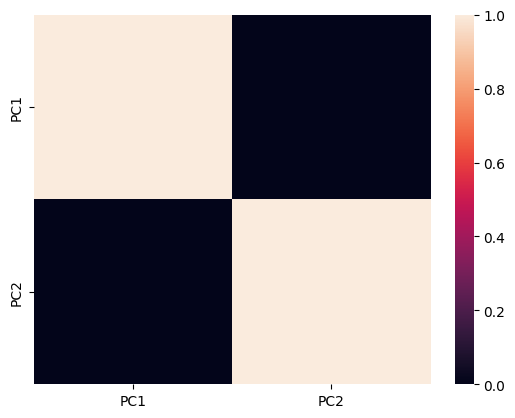

In [27]:
sns.heatmap(pca_final.corr())

Drop Features incorporated into PCA. We will also drop FGM, which is redundant; Shot_Result serves the same purpose and has been converted to an integer.

In [28]:
final_shotlog=pd.concat([final_shotlog,pca_final], axis=1)
final_shotlog=final_shotlog.drop(['PERIOD','TOUCH_TIME','DRIBBLES','PTS_TYPE','FGM'],axis=1)


Features by game

One-Hot encoding for categorical variables ()

In [29]:
final_shotlog=final_shotlog.drop(['Matchup','player_name','CLOSEST_DEFENDER','Date'],axis=1)

In [30]:
final_shotlog=final_shotlog.drop(['Away Team','Home Team','Player_Team'],axis=1)

with open('shotlog.pkl', 'wb') as file:
    pickle.dump(final_shotlog, file)

In [31]:
Encoder=OneHotEncoder(sparse_output=False)
categorical=final_shotlog.select_dtypes(include=['object']).columns.tolist()
one_hot=Encoder.fit_transform(final_shotlog[categorical])
oh_df=pd.DataFrame(one_hot, columns=Encoder.get_feature_names_out(categorical))
shot_log_encoded=pd.concat([final_shotlog, oh_df], axis=1)
shot_log_encoded=shot_log_encoded.drop(categorical, axis=1)


In [32]:
with open('encoded.pkl', 'wb') as file:
    pickle.dump(shot_log_encoded, file)